In [2]:
import astropy as ast
from astropy.coordinates import EarthLocation
from astroplan.moon import moon_phase_angle
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

### Generating Lunar Phase Data

In [3]:
# Range is 150 years, almost the limit available to us from the astropy API
times = pd.date_range(start="2000-01-01-00-00-00", end="2020-01-01-00-00-00", freq='1D')

# Location is the Medicina Radio Observatory, located in Italy. Chosen for proximity to Greece
# Moon phase doesn't really vary with respect to location on Earth, only the orientation of the moon changes;
# location is included in dataset for completeness
loc = EarthLocation.of_site('medicina')
rows = defaultdict(list)


In [ ]:
# Fetch moon phase data for all dates in range
for time in times:
    time = ast.time.Time(time.to_pydatetime())
    print(time)
    rows['time'].append(time)
    rows['location'].append(str(loc))
    rows['moon_phase'].append(moon_phase_angle(time).value)

celestial_bodies = pd.DataFrame(rows)
celestial_bodies.to_csv('moon_phase_data.csv', index=False)

In [4]:
# Load the generated data
data = pd.read_csv('moon_phase_data.csv')

In [5]:
# Convert to datetime objects
data['time'] = pd.to_datetime(data['time'])

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


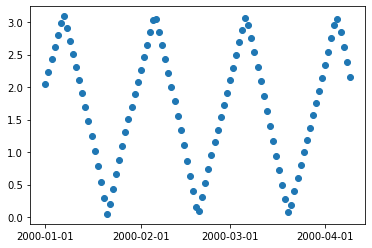

In [6]:
# Plot the first 100 datapoints to understand the data
fig, ax = plt.subplots()
dates = data['time'][:100]
phases = data['moon_phase'][:100]
plt.plot_date(dates, phases)
date_form = DateFormatter("%Y-%m-%d")
ax.xaxis_date()
ax.xaxis.set_major_formatter(date_form)
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.show()

In [8]:
# Partition the data into training and test sets

num_days = len(data['time'])
split = int(num_days * 0.8)
# Convert to # days since 2000-01-01
X = np.array(list(range(num_days)))
y = data['moon_phase']
X_train = X[:split]
y_train = y[:split]
X_test = X[split:]
y_test = y[split:]

In [9]:
import scipy.optimize

def fit_sin(X_train, y_train):
    '''
    Fit a sin curve to (X_train, y_train), and return the parameters omega, phi
    '''
    fftfreq_X_train = np.fft.fftfreq(len(X_train)) 
    Fy_train = abs(np.fft.fft(y_train))
    f = abs(fftfreq_X_train[np.argmax(Fy_train[1:]) + 1]) # ignore the 0-frequency peak
    omega = 2 * np.pi * f
    A = np.std(y_train)
    c = np.mean(y_train)
    p0 = [omega, 0] # p0 gives the initial estimates of the parameters for curve_fit

    def sin_model(t, omega, phi):  
        return A * np.sin(omega * t + phi) + np.pi / 2
    
    popt, _ = scipy.optimize.curve_fit(sin_model, X_train, y_train, p0)
    omega, phi = popt
    # Values for A and c are ignored; they should be both be pi/2 so we don't need to approximate them
    return omega, phi

def get_pred_func(omega, phi):
    '''
    Get the predicted function that takes in t (in days, as defined above) and outputs the lunar phase in radians
    '''
    def pred_func(t):
        t = t + phi/omega
        A = np.pi / 2
        c = np.pi / 2
        T = 2 * np.pi / omega
        m = 4 * A / T
        n = (t - T/4) // (T/2) + 1
        if T/4 <= (t % T) <= 3*T/4:
            return -m * (t) + (2 * n * A) + c
        else:
            return m * (t) - (2 * n * A) + c
    return pred_func

In [10]:
# Learn the function parameters
omega, phi = fit_sin(X_train, y_train)
pred_func = get_pred_func(omega, phi)

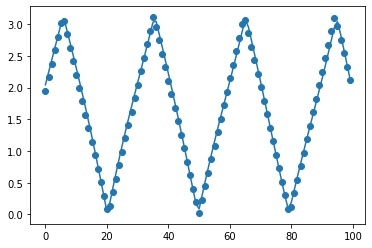

In [11]:
# Plot against subset of training data
fig, ax = plt.subplots()
pred_train = np.array([pred_func(t) for t in X_train[:100]])
plt.scatter(X_train[:100], pred_train)
plt.plot(X_train[:100], y_train[:100])
plt.show()

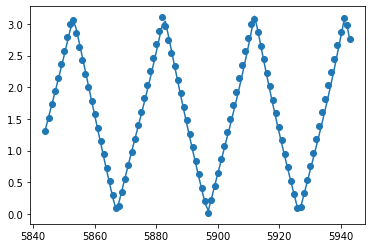

In [12]:
# Plot against subset of test data
fig, ax = plt.subplots()
pred_test = np.array([pred_func(t) for t in X_test[:100]])
plt.scatter(X_test[:100], pred_test)
plt.plot(X_test[:100], y_test[:100])
plt.show()

In [13]:
# Compute the MSE test error
pred_test = np.array([pred_func(t) for t in X_test])
print('MSE test error:', np.mean((pred_test - y_test) ** 2))

MSE test error: 0.006948350763981869
